# USING ARTIFICIAL INTELLIGENCE (DEEP NEURAL NETWORKS) IN HEALTHCARE DIAGNOSTICS FOR LYMPHATIC CANCER

MODELLING IMAGE DATA FROM LYMPHATIC NODE SCANS TO MEASURE MODEL PERFORMANCE (CORRECT DIAGNOSIS OF CANCER)

IMPORTING RELEVANT LIBRARIES

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2 
import tensorflow as tf 
import time 
import os, os.path
import PIL
from PIL import Image
import glob
import sys
import pathlib
import imutils
import shutil
import imageio as iio
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from PIL import Image
from tensorflow.keras import utils
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, MaxPooling2D, Flatten, Rescaling, Activation, Softmax, GlobalAveragePooling3D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import TensorBoard
import time
import keras_tuner as kt

In [5]:
import warnings
warnings.filterwarnings('ignore') #to reduce incessant warning 

IMAGE CONVERSION FROM .tif to .png

In [28]:
#IMAGE CONVERSION TO PNG
base_path = '/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/cancer-detection-dataset/'
new_path = '/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/converted_to_png/*'
for infile in os.listdir(base_path):
    print ("file : " + infile)
    read = cv2.imread(base_path + infile)
    outfile = infile.split('.')[0] + '.png'
    cv2.imwrite(new_path+outfile,read)

file : e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif
file : 1996c210f020134e986823ca7d4df0a70a799c34.tif
file : f7d0c81604f942756bf9326fc00ca210cbb205fa.tif
file : f683eb1dbac270cdb404dbe67adecde6eb765c26.tif
file : 68a36318a39cd5b08b4df526006ad923a8c67bdf.tif
file : 8743179fa8d2930b1a09f506da4ea0871f415609.tif
file : 9cc8289d5d08f875e841b9e002387e3306450b8e.tif
file : 1b51309490235adbbf434550f1ad0335d0f2acee.tif
file : 745a44c45dd89869fc2a1e87b0350ef8be92656f.tif
file : e100be8df4d61b749fa7c184adb37bf8614a99f3.tif
file : 8a3bbbb15fad60e3d4837447942afe6b80b8e879.tif
file : c3aea2a5f07e03971cef31c711f656e965f0eb80.tif
file : 3392ae4101c50cdd3eb1af6127eecb2c9ba2dd8f.tif
file : 3e96cd02bf07068a7a097e9e0c94ba9074b8f48d.tif
file : 8962ee904d1cdbfd8e1788e8fe2372e652bf6e84.tif
file : 5fd239281099b27c50fa0cb0a99003e981d5fa3d.tif
file : 82da86e9e12ac9482b131f4156405f4528a60034.tif
file : 8b55aec6ffc5c60805ac5a5cdd834d43a7a983a4.tif
file : 56ba33803cfec481fd48cc6f7a553492a759e355.tif
file : 1a0ca

SORTING DATA INTO TWO LISTS: TRUE POSITIVES AND TRUE NEGATIVES 

In [6]:
#TPTN SORTER

# =============================================================================
# # Read in images and assign labels to pandas dataframe
# =============================================================================

df_png_labels = pd.read_csv(r'/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/png_labels.csv')

df_png_labels

# =============================================================================
# # Create 2 lists, to house the true positives (TPs) and true negs (TNs)
# =============================================================================

TP = []
TN = []
for row in df_png_labels.itertuples():
    if row.label==1:
        TP.append(row.id)
    else:
        TN.append(row.id)
        
print(len(TP))
print(len(TN))

10000
10000


USING A FOR LOOP TO READ-IN IMAGES USING THEIR FILE PATHS 

In [15]:
#do we need to shuffle? yes 

#shuffled_labels = df_png_labels.sample(frac=1, random_state = 10).reset_index(drop=True) #shuffle all rows and reset index 


#seperate x and y variables 
yvar = df_png_labels.drop('id', axis=1, inplace = False)
xvar = df_png_labels.drop('label', axis=1, inplace = False)


#standardize data, not needed as it affects modelling the data 
#all_images = []
#for all in xvar['id']:
#to_normalize_path = f'/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/converted_to_png/{all}'
#all_img = cv2.imread(to_normalize_path)
#all_images.append(all_img)
    
#all_images = (all_images - np.mean(all_images))/np.std(all_images)
#yvar = yvar['label']

#Xtr, Xtest, Ytr, Ytest = train_test_split(all_images, yvar, test_size = 0.3, random_state = 10)
#train_images = np.array(Xtr)
#train_labels = np.array(Ytr)
#test_images = np.array(Xtest)
#test_labels = np.array(Ytest)

Xtr, Xtest, Ytr, Ytest = train_test_split(xvar, yvar, test_size = 0.2, random_state = 10)

train_images = []
for pic in Xtr['id']:
    new_file_path = f'/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/converted_to_png/{pic}'
    images_tr = cv2.imread(new_file_path)
    train_images.append(images_tr)
    train_labels = Ytr['label'] #converting to arrays 
    #we now have our training images and training labels!!


test_images = []
for item in Xtest['id']:
    test_path =  f'/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/converted_to_png/{item}'
    images_tst = cv2.imread(test_path)
    test_images.append(images_tst)
    test_labels = Ytest['label'] #we now have our test images and labels!!
    #use the test images and labels to test model performance 
    

train_labels = np.array(train_labels).reshape(-1,1)
test_labels = np.array(test_labels).reshape(-1,1)
test_images = np.array(test_images)  
train_images = np.array(train_images)

ARTIFICIAL NEURAL NETWORK MODEL ARCHITECTURE 

In [16]:

# Define NN
model = Sequential()
model.add(Rescaling(scale=1./255))
model.add(Flatten(input_shape = (96, 96, 3)))
model.add(Dense(128, activation = 'relu')) #input_dim
model.add(Dense(96, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(36, activation = 'relu'))
model.add(Dense(24, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(9, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
#model.add(GlobalAveragePooling3D()) #or TRY model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) #try sigmoid later 

#model.add(Flatten())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#try with loss = binary_crossentropy and a different optimizer other than adam
#categorical cross entropy loss does not work with softmax and gives an error
#binary cross entropy does not work without softmax and gives an error


# Fit and predict with NN
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=0) #test the epochs and try smaller batch sizes

MEASURING MODEL PERFORMANCE (ACCURACY, LOSS, AUC SCORE, RECALL, PRECISION)

In [17]:
#<keras.callbacks.History at 0x7f95024c6eb0>
#The number of training examples used in the estimate of the error gradient is a hyperparameter for the learning algorithm called the “batch size,” or simply the “batch.”
#Smaller batch sizes are used for two main reasons:Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error.
#Smaller batch sizes make it easier to fit one batch worth of training data in memory (i.e. when using a GPU).
#A third reason is that the batch size is often set at something small, such as 32 examples, and is not tuned by the practitioner. Small batch sizes such as 32 do work well generally.

train_pred = model.predict(train_images)
test_pred = model.predict(test_images)

test_pred_binary = test_pred > 0.5
train_pred_binary = train_pred > 0.5 

In [18]:
from sklearn.metrics import roc_auc_score

print('Accuracy on training set: %.2f' % accuracy_score(train_labels, train_pred_binary)) #get accuracy function
print('Accuracy on test set: %.2f' % accuracy_score(test_labels, test_pred_binary))
print('AUC score on training set: %.2f' % roc_auc_score(train_labels, train_pred))
print('AUC score on test set: %.2f' % roc_auc_score(test_labels, test_pred))

#all performance metrics further improved once I did 20% test split rather than the previous 30% test spilit 

Accuracy on training set: 0.74
Accuracy on test set: 0.72
AUC score on training set: 0.82
AUC score on test set: 0.78


In [ ]:
#According to Ayush Joshi, the Accuracy metric is fixed but every time you retrain the model, 
#it will have different weights and therefore different performance unless the model converges 
#I suspect that the model does not converge in 10 epochs and therefore sometimes you are lucky 
#with the model initialisation and get good results in 10 epochs and sometimes you don't. 

In [19]:
model.summary()
model.evaluate(test_images, test_labels) #prints out test_loss, test_acc
history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 96, 96, 3)           0         
                                                                 
 flatten_1 (Flatten)         (32, 27648)               0         
                                                                 
 dense_10 (Dense)            (32, 128)                 3539072   
                                                                 
 dense_11 (Dense)            (32, 96)                  12384     
                                                                 
 dense_12 (Dense)            (32, 64)                  6208      
                                                                 
 dense_13 (Dense)            (32, 36)                  2340      
                                                                 
 dense_14 (Dense)            (32, 24)                 

In [20]:
#recall - The recall is the ratio tp / (tp + fn) - the best value is 1, worst value is 0
print('Recall on training set: %.2f' % recall_score(train_labels, train_pred_binary, average = 'binary'))
print('Recall on test set: %.2f' % recall_score(test_labels, test_pred_binary, average='binary'))


#precision - The precision is the ratio tp / (tp + fp)  - the best value is 1, worst value is 0
print('Precision on training set: %.2f' % precision_score(train_labels, train_pred_binary, average = 'binary'))
print('Precision on test set: %.2f' % precision_score(test_labels, test_pred_binary, average='binary'))


#compute TP, FP, TN, FN:
#Then use their values to compute sensitivieity and specificity, hopefully we can make a graph out of it that shows the way they change according to
#different parameters. Sensitivity measures the proportion of actual positives that are correctly identified as such (tp / (tp + fn)). 
#Specificity measures the proportion of actual negatives that are correctly identified as such (tn / (tn + fp)).

#as a metric, compute the time it takes model to fit to data metric? 


#plot (don't know what - hyperparameter tuning resulting graphs can be plotted)
#show images using imshow or something

Recall on training set: 0.78
Recall on test set: 0.77
Precision on training set: 0.73
Precision on test set: 0.70


# HYPER-PARAMETER TUNING 



In [33]:

#first do a 0.15 train test split just like in samuel's tuning 

xtrain, xtest, ytrain, ytest = train_test_split(xvar, yvar, test_size = 0.15, random_state = 10)

training_images = []
for pics in xtrain['id']:
    n_f_p = f'/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/converted_to_png/{pics}'
    images_train = cv2.imread(n_f_p)
    training_images.append(images_train)
    training_labels = ytrain['label'] #converting to arrays 
    #we now have our training images and training labels!!


testing_images = []
for items in xtest['id']:
    tt_path =  f'/Users/adetutusadiq/Downloads/Data Modelling/cancer-detection_un/converted_to_png/{items}'
    images_test = cv2.imread(tt_path)
    testing_images.append(images_test)
    testing_labels = ytest['label'] #we now have our test images and labels!!
    #use the test images and labels to test model performance 
    

training_labels = np.array(training_labels).reshape(-1,1)
testing_labels = np.array(testing_labels).reshape(-1,1)
testing_images = np.array(testing_images)  
training_images = np.array(training_images)

print(len(training_labels))
print(len(training_images))

17000
17000


FINDING THE OPTIMAL NUMBER OF UNITS WITHIN EACH LAYER TO FIND BEST VERSION OF MODEL

In [38]:
def model_builder(hp):
    Model = keras.Sequential()
    Model.add(Rescaling(1./255))

    Model.add(Flatten(input_shape = (96, 96, 3)))
 
    hp_units1 = hp.Int('units1', min_value=1, max_value=128, step=32)
    Model.add(Dense(units = hp_units1, activation = 'relu'))
    hp_units2 = hp.Int('units2', min_value=1, max_value=128, step=32)
    Model.add(Dense(units = hp_units2, activation = 'relu'))
    hp_units3 = hp.Int('units3', min_value=1, max_value=128, step=32)
    Model.add(Dense(units = hp_units3, activation = 'relu'))
    hp_units4 = hp.Int('units4', min_value=1, max_value=128, step=32)
    Model.add(Dense(units = hp_units4, activation = 'relu'))
    hp_units5 = hp.Int('units5', min_value=1, max_value=128, step=32)              
    Model.add(Dense(units = hp_units5, activation = 'relu'))
    hp_units6 = hp.Int('units6', min_value=1, max_value=128, step=32)        
    Model.add(Dense(units = hp_units6, activation = 'relu'))
    hp_units7 = hp.Int('units7', min_value=1, max_value=128, step=32)           
    Model.add(Dense(units = hp_units7, activation = 'relu'))
    hp_units8 = hp.Int('units8', min_value=1, max_value=128, step=32)  
    Model.add(Dense(units = hp_units8, activation = 'relu'))
    hp_units9 = hp.Int('units9', min_value=1, max_value=128, step=32)   
    Model.add(Dense(units = hp_units9, activation = 'relu'))

    Model.add(Dense(1, activation = 'sigmoid'))
  
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    Model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
    return Model


In [39]:
#INSTANTIATE TUNER AND PERFORM HYPERTUNING
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=4, overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


#Run the hyperparameter search
tuner.search(training_images, training_labels, epochs=50, validation_split=0.15, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in 1st densely-connected
layer is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(f"""
The hyperparameter search is complete. The optimal number of units in 2nd densely-connected
layers is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


print(f"""
The hyperparameter search is complete. The optimal number of units in 3rd densely-connected
layers is {best_hps.get('units3')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


print(f"""
The hyperparameter search is complete. The optimal number of units in 4th densely-connected
layers is {best_hps.get('units4')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



print(f"""
The hyperparameter search is complete. The optimal number of units in 5th densely-connected
layers is {best_hps.get('units5')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


print(f"""
The hyperparameter search is complete. The optimal number of units in 6th densely-connected
layers is {best_hps.get('units6')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


print(f"""
The hyperparameter search is complete. The optimal number of units in 7th densely-connected
layers is {best_hps.get('units7')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


print(f"""
The hyperparameter search is complete. The optimal number of units in 8th densely-connected
layers is {best_hps.get('units8')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


print(f"""
The hyperparameter search is complete. The optimal number of units in 9th densely-connected
layers is {best_hps.get('units9')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



Trial 44 Complete [00h 00m 16s]
val_accuracy: 0.5117647051811218

Best val_accuracy So Far: 0.7160784602165222
Total elapsed time: 00h 07m 20s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in 1st densely-connected
layer is 33 and the optimal learning rate for the optimizer
is 0.0001.


The hyperparameter search is complete. The optimal number of units in 2nd densely-connected
layers is 65 and the optimal learning rate for the optimizer
is 0.0001.


The hyperparameter search is complete. The optimal number of units in 3rd densely-connected
layers is 97 and the optimal learning rate for the optimizer
is 0.0001.


The hyperparameter search is complete. The optimal number of units in 4th densely-connected
layers is 97 and the optimal learning rate for the optimizer
is 0.0001.


The hyperparameter search is complete. The optimal number of units in 5th densely-connected
layers is 97 and the optimal learning rate for the optimizer
is

In [40]:
print(best_hps)

TESTING OUR BEST MODEL TO FIND THE OPTIMAL NUMBER OF EPOCHS TO TRAIN THE MODEL WITH HYPERPARAMETERS OBTAINED FROM THE SEARCH


In [45]:
#TESTING OUR BEST MODEL 

#Train the model. Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_images, training_labels, epochs=50, validation_split=0.15)

val_acc_per_epoch = history.history['val_accuracy']

best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6700 - accuracy: 0.5691 - val_loss: 0.6386 - val_accuracy: 0.6145
Epoch 2/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6408 - accuracy: 0.6090 - val_loss: 0.6360 - val_accuracy: 0.6145
Epoch 3/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6355 - accuracy: 0.6201 - val_loss: 0.6347 - val_accuracy: 0.6251
Epoch 4/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6292 - accuracy: 0.6226 - val_loss: 0.6568 - val_accuracy: 0.6125
Epoch 5/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6240 - accuracy: 0.6278 - val_loss: 0.6409 - val_accuracy: 0.6251
Epoch 6/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6175 - accuracy: 0.6406 - val_loss: 0.6129 - val_accuracy: 0.6337
Epoch 7/50
452/452 [==============================] - 2s 4ms/step - loss: 0.6045 - accuracy: 0.6645 - val_loss: 0.6191 - val_accuracy: 0.6855
Epoch 

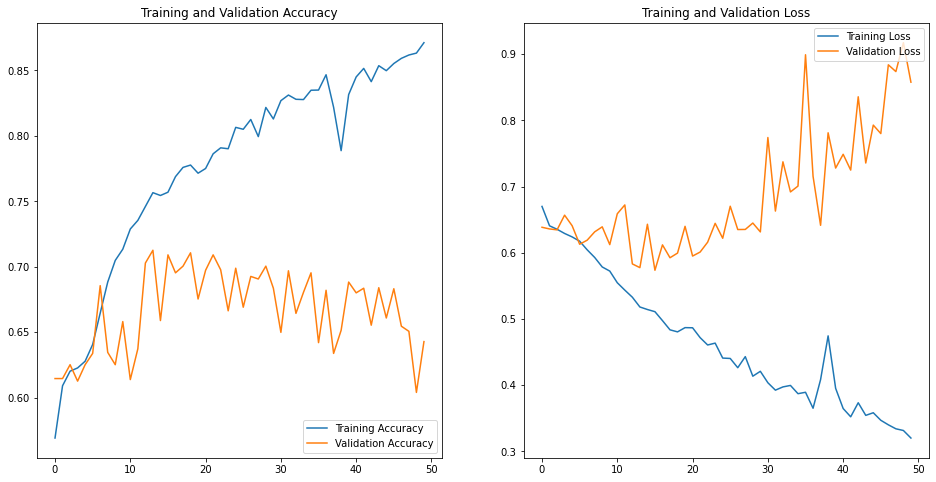

In [49]:

#VISUALIZING THE ABOVE 
acc_per_epoch = history.history['accuracy']
val_acc_per_epoch = history.history['val_accuracy']

loss_per_epoch = history.history['loss']
val_loss_per_epoch = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_per_epoch, label='Training Accuracy')
plt.plot(epochs_range, val_acc_per_epoch, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_per_epoch, label='Training Loss')
plt.plot(epochs_range, val_loss_per_epoch, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
#BEST EPOCH IS 14 LOOKING AT GRAPH ABOVE 

RE-INSTANTIATE THE HYPERMODEL AND TRAIN IT WITH THE OPTIMAL NUMBER OF EPOCHS FROM ABOVE 

In [50]:

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(training_images, training_labels, epochs=best_epoch, validation_split=0.15)

Epoch 1/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6654 - accuracy: 0.5774 - val_loss: 0.6543 - val_accuracy: 0.6000
Epoch 2/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6432 - accuracy: 0.6130 - val_loss: 0.6447 - val_accuracy: 0.6027
Epoch 3/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6320 - accuracy: 0.6179 - val_loss: 0.6265 - val_accuracy: 0.6259
Epoch 4/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6265 - accuracy: 0.6208 - val_loss: 0.6358 - val_accuracy: 0.6149
Epoch 5/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6216 - accuracy: 0.6311 - val_loss: 0.6224 - val_accuracy: 0.6341
Epoch 6/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6161 - accuracy: 0.6372 - val_loss: 0.6214 - val_accuracy: 0.6329
Epoch 7/14
452/452 [==============================] - 2s 4ms/step - loss: 0.6105 - accuracy: 0.6486 - val_loss: 0.6183 - val_accuracy: 0.6318
Epoch 

EVALUATE HYPERTUNED MODEL ON TEST DATA

In [51]:

eval_result = hypermodel.evaluate(testing_images, testing_labels)
print("[test loss, test accuracy]:", eval_result)

#accuracy is 70% 

94/94 [==============================] - 0s 2ms/step - loss: 0.5803 - accuracy: 0.7020
[test loss, test accuracy]: [0.5802823901176453, 0.7020000219345093]


In [ ]:

#Use this link to evaluate your results, improve model, and once model performs better, use the better model 
#to classify an image that wasn't included in the training or validation sets. But where will we get that if we have 
#used all available data during training? 

https://www.tensorflow.org/tutorials/images/classification
#predictions - visualize by plotting - this will go in report 

